In [12]:
alpha = 8
dell = -4

In [13]:
# 16th June 2024
import matplotlib.pyplot as plt
import uproot, time, sys, warnings, os
warnings.filterwarnings('ignore')
sys.path.append('/w/hallc-scshelf2102/xem2/ashard')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import colormaps as cmaps
from scipy.interpolate import griddata
from scipy import stats
from scipy.optimize import curve_fit
from common_functions import gaussian, shaxes, hw, Ei, Mp
from common_functions import E as R
from scipy.constants import physical_constants

run = 17203
file = '_e1'
folder = 'wwalks/plots/'
# delh = 22
delh = dell + 2
hdell = -8
hdelh = 8
ypl = -0.04
yph = 0.07

start_time = time.time()
mp = physical_constants['proton mass energy equivalent in MeV'][0] / 1000 # Proton mass in GeV
E = 10.551 # Beam energy in GeV
dabino = 200 # Data bin number

def get_kin(run_number):
    kinematic_settings = [
        {"Setting Number": 1, "SHMS Momentum": -4.93, "SHMS Angle": 26, "HMS Momentum": 6.476, "HMS Angle": 19.54, "Run Numbers": [17166, 17167, 17191, 17192, 17193, 17194, 17195, 17196, 17197, 17198, 17199], "Simulation File": "coin_elastics_m6p476.root"},
        {"Setting Number": 2, "SHMS Momentum": -8, "SHMS Angle": 16.54, "HMS Momentum": 4.17, "HMS Angle": 29.37, "Run Numbers": [17177], "Simulation File": "coin_elastics_m4p17.root"},
        {"Setting Number": 3, "SHMS Momentum": -8, "SHMS Angle": 15.09, "HMS Momentum": 3.77, "HMS Angle": 31.69, "Run Numbers": [17181], "Simulation File": "coin_elastics_m3p77.root"},
        {"Setting Number": 4, "SHMS Momentum": -8, "SHMS Angle": 13.67, "HMS Momentum": 3.35, "HMS Angle": 34.32, "Run Numbers": [17182], "Simulation File": "coin_elastics_m3p35.root"},
        {"Setting Number": 5, "SHMS Momentum": -8, "SHMS Angle": 12.24, "HMS Momentum": 2.94, "HMS Angle": 37.34, "Run Numbers": [17186], "Simulation File": "coin_elastics_m2p94.root"},
        {"Setting Number": 6, "SHMS Momentum": -8, "SHMS Angle": 10.78, "HMS Momentum": 2.51, "HMS Angle": 40.93, "Run Numbers": [17187], "Simulation File": "coin_elastics_m2p51.root"},
        {"Setting Number": 7, "SHMS Momentum": -8, "SHMS Angle": 9.25, "HMS Momentum": 2.08, "HMS Angle": 45.32, "Run Numbers": [17190], "Simulation File": "coin_elastics_m2p08.root"},
        {"Setting Number": 8, "SHMS Momentum": -6.286, "SHMS Angle": 20, "HMS Momentum": 5.107, "HMS Angle": 24.89, "Run Numbers": range(17203, 17205), "Simulation File": "coin_elastics_m5p107.root"},
        {"Setting Number": 9, "SHMS Momentum": -7.626, "SHMS Angle": 15, "HMS Momentum": 3.738, "HMS Angle": 31.86, "Run Numbers": [17205], "Simulation File": "coin_elastics_m3p738.root"},
        {"Setting Number": 10, "SHMS Momentum": -9.005 + 0.0261, "SHMS Angle": 10, "HMS Momentum": 2.289, "HMS Angle": 43.09, "Run Numbers": [17210], "Simulation File": "coin_elastics_m2p289.root"},
        {"Setting Number": 11, "SHMS Momentum": -9.2, "SHMS Angle": 9.24, "HMS Momentum": 2.076, "HMS Angle": 45.36, "Run Numbers": [17212], "Simulation File": "coin_elastics_m2p076.root"},
        {"Setting Number": 12, "SHMS Momentum": -9.502 + 0.0261, "SHMS Angle": 7.995 - 0.0885, "HMS Momentum": 1.739, "HMS Angle": 49.49, "Run Numbers": [17216], "Simulation File": "coin_elastics_m1p739.root"}
    ]
    
    # Search for the run number in the table
    for setting in kinematic_settings:
        if run_number in setting["Run Numbers"]:
            filepath = f"/w/hallc-scshelf2102/xem2/ashard/simc_gfortran/worksim/{setting['Simulation File']}"
            sn = setting["Setting Number"]

    filepath = filepath.split('.')[0] + file + '.root'
    code = filepath.split('worksim/')[1].split('.')[0]
    filename = f'{code}.root'
    inpath = f'/home/ashard/work/simc_gfortran/infiles/{code}.inp'
    with open(inpath, 'r') as f:
        for line in f:
            if 'spec%e%P' in line:
                sp = float(line.split()[2].split(';')[0]) / 1000
            if 'spec%e%theta' in line:
                st = float(line.split()[2].split(';')[0])
            if 'spec%p%P' in line:
                hp = float(line.split()[2].split(';')[0]) / 1000
            if 'spec%p%theta' in line:
                ht = float(line.split()[2].split(';')[0])
    return sn, sp, st, hp, ht, filepath, filename

sn, sp, st, hp, ht, filepath, filename = get_kin(run)

if filename == f'coin_elastics_m6p476{file}.root':
    runs = [17166, 17167, 17191, 17192, 17193, 17194, 17195, 17196, 17197, 17198, 17199]
    run = None
elif filename == f'coin_elastics_m5p107{file}.root':
    runs = [17203, 17204]
    run = None
else:
    runs = None

if run:     plot_title = f'Run {run} (Setting {sn}) HMS: {hp:.2f}; SHMS: -{sp:.2f} SHMS δ∈({dell},{delh}) HMS δ∈({hdell},{hdelh})'
else:       plot_title = f'Setting {sn} HMS: {hp:.2f}; SHMS: -{sp:.2f} SHMS δ∈({dell},{delh})'

print(f'Setting number {sn} SHMS Momentum {sp:.3f} SHMS Angle {st:.3f} HMS Momentum {hp:.3f} HMS Angle {ht:.3f}\nMC file {filepath}')

cos_ht, sin_ht = np.cos(np.deg2rad(ht)), np.sin(np.deg2rad(ht)) 
cos_st, sin_st = np.cos(np.deg2rad(st)), np.sin(np.deg2rad(st))

Setting number 8 SHMS Momentum 6.286 SHMS Angle 20.000 HMS Momentum 5.107 HMS Angle 24.885
MC file /w/hallc-scshelf2102/xem2/ashard/simc_gfortran/worksim/coin_elastics_m5p107_e1.root


<h2 style="text-align: center; color: pink"> Reading SIMC </h2>

In [14]:
f = uproot.open(filepath)
tree = f["h666"]
simcounts = tree.arrays(["hsdelta", "Em", "hsyptar", "hsxptar", "ssdelta", "ssyptar", "ssxptar", "Pmx", "Pmy", "Pmz", "W", "Weight"], library = 'np')

simc_cut = ((simcounts['hsdelta'] < hdelh) & (simcounts['hsdelta'] > hdell) & (np.abs(simcounts['hsyptar']) < 0.032) & (np.abs(simcounts["hsxptar"]) < 0.085)) & (simcounts['ssdelta'] > dell) & \
            (simcounts['ssdelta'] < delh) & (simcounts['ssyptar'] > ypl) & (simcounts['ssyptar'] < yph) & (np.abs(simcounts['ssxptar']) < 0.07)

hsdelta, ssdelta = simcounts["hsdelta"][simc_cut], simcounts["ssdelta"][simc_cut]
hsphi, ssphi = simcounts["hsyptar"][simc_cut], simcounts["ssyptar"][simc_cut]
hsth, ssth = simcounts["hsxptar"][simc_cut], simcounts["ssxptar"][simc_cut]
weight = simcounts["Weight"][simc_cut]
num_ev = len(hsdelta) # Number of events simulated
nevents = len(simcounts["hsdelta"])

simcmopr = hp * (1 + hsdelta / 100) # Momentum of proton
simcmoel = sp * (1 + ssdelta / 100) # Momentum of electron
simcenpr = np.sqrt(mp**2 + simcmopr**2) # Energy of proton
simcmiss = E + mp - (simcenpr + simcmoel) # Missing energy according to SIMC

simcspz = simcmoel / np.sqrt(1 + (ssth * ssth) + (ssphi * ssphi)) # pz for the electron
simchpz = simcmopr / np.sqrt(1 + (hsth * hsth) + (hsphi * hsphi)) # pz for proton
ssthrad = np.arccos((cos_st + ssphi * sin_st) / np.sqrt(1 + ssth * ssth + ssphi * ssphi)) # SIMC SHMS angle distribution
hsthrad = np.arccos((cos_ht + hsphi * sin_ht) / np.sqrt(1 + hsth * hsth + hsphi * hsphi)) # SIMC HMS angle distribution

inpr = np.tile(np.array([mp, 0, 0, 0]), (num_ev, 1)).T # The 4-vector for the initial proton
inel = np.tile(np.array([E, 0, 0, E]), (num_ev, 1)).T # The 4-vector for the initial electron beam
fipr = np.array([simcenpr, simchpz * hsth, simchpz * ((hsphi * cos_ht) - sin_ht), simchpz * ((hsphi * sin_ht) + cos_ht)]) # The 4-vector for the final proton
fiel = np.array([simcmoel, simcspz * ssth, simcspz * ((ssphi * cos_st) + sin_st), simcspz * ((-ssphi * sin_st) + cos_st)]) # The 4-vector for the final electron

q4v = inel - fiel # The 4-vector of the momentum transfer
w4v = inpr + q4v # The 4-vector of the final hadron

simcwca  = np.sqrt(w4v[0]**2 - ((w4v[1]**2) + (w4v[2]**2) + (w4v[3]**2))) # SIMC invariant mass (calculated)
simcemis = inel[0] + inpr[0] - (fiel[0] + fipr[0]) # Missing energy from SIMC
simcpxm  = inpr[1] + inel[1] - (fipr[1] + fiel[1]) # SIMC missing momentum in x-direction
simcpym  = inpr[2] + inel[2] - (fipr[2] + fiel[2]) # SIMC missing momentum in y-direction
simcpzm  = inpr[3] + inel[3] - (fipr[3] + fiel[3]) # SIMC missing momentum in z-direction

def get_charge(r):
    dpath = f'/volatile/hallc/xem2/ashard/REPORT_OUTPUT/COIN/HeeP/replay_coin_production_{r}_-1.report'
    with open(dpath, 'r') as file:
        for line in file:
            if 'HMS BCM4A Beam Cut Charge' in line:
                charge = float(line.split()[5])
    return charge

def get_normfac():
    code = filepath.split('worksim/')[1].split('.')[0]
    spath = f'/home/ashard/work/simc_gfortran/outfiles/{code}.hist'
    with open(spath, 'r') as file:
        for line in file:
            if 'normfac' in line:
                nf = float(line.split()[2])
    return nf

<h2 style="text-align: center; color: lightblue"> Calculating Data 4-vectors </h2>

In [15]:
if runs:
    print("Processing multiple runs")
    # Define the branches to load for HMS and SHMS electrons
    he_branch_names = ["H.gtr.dp", "H.cal.etottracknorm", "H.gtr.ph", "H.gtr.th", "H.cer.npeSum", "H.kin.secondary.emiss", "H.gtr.px", "H.gtr.py", "H.gtr.pz"]
    pe_branch_names = ["P.gtr.dp", "P.cal.etottracknorm", "P.dc.yp_fp", "P.gtr.ph", "P.gtr.th", "P.ngcer.npeSum", "P.kin.primary.W", "P.gtr.px", "P.gtr.py", "P.gtr.pz", 'P.kin.primary.scat_ang_deg', 'P.kin.primary.scat_ang_rad']

    # Function to load arrays from a single run
    def load_run_data(run):
        tree = uproot.open(f'/volatile/hallc/xem2/ashard/ROOTfiles/COIN/HeeP/coin_replay_production_{run}_-1.root:T')
        # for key in tree:
        #     print(key)
        he_data = tree.arrays(he_branch_names, library = 'np')
        pe_data = tree.arrays(pe_branch_names, library = 'np')
        return he_data, pe_data

    # Initialize lists to store data from all runs
    he_list, pe_list = [], []
    charge = 0.0
    for run in runs:
        he_data, pe_data = load_run_data(run)
        he_list.append(he_data)
        pe_list.append(pe_data)
        charge += get_charge(run)

    # Combine arrays from multiple runs into single dictionaries
    def combine_runs(arrays_list):
        combined = {}
        for key in arrays_list[0].keys():
            combined[key] = np.concatenate([run_data[key] for run_data in arrays_list])
        return combined

    helectrons = combine_runs(he_list)
    pelectrons = combine_runs(pe_list)

else:
    print("Processing a single run")
    tree = uproot.open(f'/volatile/hallc/xem2/ashard/ROOTfiles/COIN/HeeP/coin_replay_production_{run}_-1.root:T')
    helectrons = tree.arrays(["H.gtr.dp", "H.cal.etottracknorm", "H.gtr.ph", "H.gtr.th", "H.cer.npeSum", "H.kin.secondary.emiss", "H.gtr.px", "H.gtr.py", "H.gtr.pz"], library = 'np')
    pelectrons = tree.arrays(["P.gtr.dp", "P.cal.etottracknorm", "P.gtr.ph", "P.gtr.th", "P.ngcer.npeSum", "P.kin.primary.W", "P.gtr.px", "P.gtr.py", "P.gtr.pz", 'P.kin.primary.scat_ang_deg', 'P.kin.primary.scat_ang_rad'], library = 'np')
    charge = get_charge(run)

# Define the cuts
data_cut = (helectrons['H.gtr.dp'] < hdelh) & (helectrons['H.gtr.dp'] > hdell) & (np.abs(helectrons['H.gtr.ph']) < 0.032) & (np.abs(helectrons['H.gtr.th']) < 0.085) & (pelectrons['P.gtr.dp'] > dell) & (pelectrons['P.gtr.dp'] < delh)
pdata_cut = ((pelectrons['P.gtr.dp'] > -10) & (pelectrons['P.gtr.dp'] < 22) & (pelectrons['P.ngcer.npeSum'] > 2)) & (pelectrons['P.gtr.ph'] > ypl) & (pelectrons['P.gtr.ph'] < yph) & (np.abs(pelectrons['P.gtr.th']) < 0.07) & (pelectrons['P.cal.etottracknorm'] > 0.7)

combined_mask = pdata_cut & data_cut # Combines SHMS and HMS cuts and only allows events that pass both the cuts

# Read in the branches
hdp = helectrons["H.gtr.dp"][combined_mask]
hth = helectrons['H.gtr.th'][combined_mask]
hphi = helectrons['H.gtr.ph'][combined_mask]

sdp = pelectrons['P.gtr.dp'][combined_mask]
sth = pelectrons['P.gtr.th'][combined_mask]
sphi = pelectrons['P.gtr.ph'][combined_mask]
sscatrad = pelectrons['P.kin.primary.scat_ang_rad'][combined_mask]

# Make the yptar dependent δ correction
sdp = sdp - (alpha * sphi)
    
numev = len(sdp)
# print(f'Number of good events for run {run} are {numev}')

mopr = hp * (1 + hdp / 100) # Momentum of the scattered proton
enpr = np.sqrt(mp**2 + mopr**2) # Energy of the scattered proton
enel = np.abs(sp) * (1 + sdp / 100) # Energy of scattered electrons

spz = enel / np.sqrt(1 + (sth * sth) + (sphi * sphi))
hpz = mopr / np.sqrt(1 + (hth * hth) + (hphi * hphi))
sthrad = np.arccos((cos_st + sphi * sin_st) / np.sqrt(1 + sth * sth + sphi * sphi)) # Data SHMS angle distribution
hthrad = np.arccos((cos_ht + hphi * sin_ht) / np.sqrt(1 + hth * hth + hphi * hphi)) # Data HMS angle distribution

dipr = np.tile(np.array([mp, 0, 0, 0]), (numev, 1)).T # The 4-vector for the initial proton
diel = np.tile(np.array([E, 0, 0, E]), (numev, 1)).T # The 4-vector for the initial electron beam
dfpr = np.array([enpr, hpz * hth, hpz * ((hphi * cos_ht) - sin_ht), hpz * ((hphi * sin_ht) + cos_ht)]) # The 4-vector for the final proton
dfel = np.array([enel, spz * sth, spz * ((sphi * cos_st) + sin_st), spz * ((-sphi * sin_st) + cos_st)]) # The 4-vector for the final electron

dq4v = diel - dfel # Data 4-vector of the momentum transfer
dw4v = dipr + dq4v # Data 4-vector of the final hadron

dwma = np.sqrt(dw4v[0]**2 - ((dw4v[1]**2) + (dw4v[2]**2) + (dw4v[3]**2))) # Data invariant mass
demi = diel[0] + dipr[0] - (dfel[0] + dfpr[0]) # Missing energy from Data
dpxm = dipr[1] + diel[1] - (dfpr[1] + dfel[1]) # Data missing momentum in x-direction
dpym = dipr[2] + diel[2] - (dfpr[2] + dfel[2]) # Data missing momentum in y-direction
dpzm = dipr[3] + diel[3] - (dfpr[3] + dfel[3]) # Data missing momentum in z-direction

normfac = get_normfac()
wfac = (weight * normfac) / nevents

Processing multiple runs


<h2 style = "text-align: center; color: lightgreen"> Fitting as a fiddle </h2>

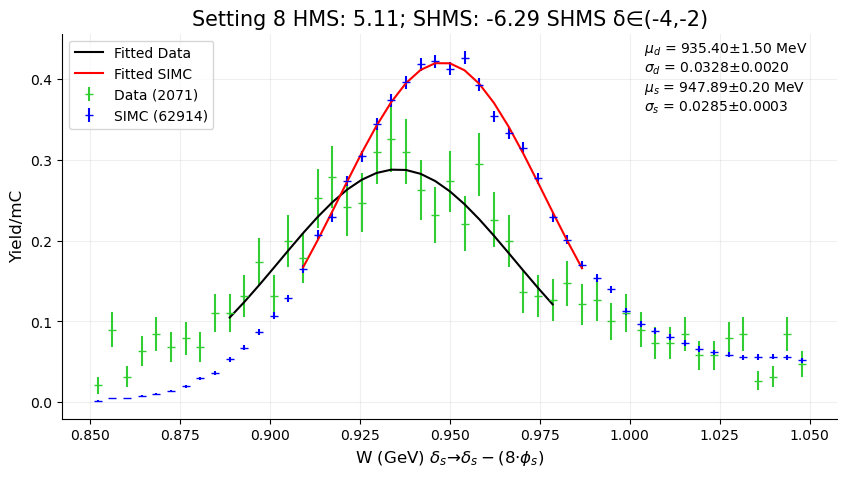

In [ ]:
def fitter(array = None, bins = None, range = None, label = 'Data', xlabel = None, norm = None, ylabel = None, title = plot_title, yscale = None, color = None, fitcol = None, weights = None, fit = True, fitcover = 0.4):
    mask = np.isfinite(array)
    array = array[mask]
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    l = label.lower()[0]
    if l == 'd':  color, fitcol, weights = 'limegreen', 'black', 1 / charge
    elif l == 's':         color, fitcol, weights = 'blue', 'red', wfac
    else:  color, fitcol, weights = 'red', 'yellow', 1 / charge

    if np.isscalar(weights):  weights = np.ones_like(array) * weights
    else: weights = weights[mask]

    # Create histogram bins and compute counts
    if bins == None:   bin_counts, bin_edges = np.histogram(array, bins = 'auto', weights = weights)
    else:
        bins = np.linspace(bins[0], bins[1], bins[2])
        bin_counts, bin_edges = np.histogram(array, bins = bins, weights = weights)
        sumw2, _ = np.histogram(array, bins = bins, weights = weights**2)
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
    yerr = np.sqrt(sumw2)
    

    # If no fit range is provided, determine it automatically around the peak
    if range is None:
        max_idx = np.argmax(bin_counts)
        threshold = fitcover * bin_counts[max_idx]
        left_idx = max_idx
        while left_idx > 0 and bin_counts[left_idx] > threshold:
            left_idx -= 1
        right_idx = max_idx
        while right_idx < len(bin_counts) - 1 and bin_counts[right_idx] > threshold:
            right_idx += 1
        x_min, x_max = bin_centers[left_idx], bin_centers[right_idx]
    else:
        x_min, x_max = range[0], range[1]

    if norm:
        # Normalize the histogram so the peak is 1
        maxbin_content = np.max(bin_counts)
        scaling_fac = 1 / maxbin_content
        normalized_bin_counts = bin_counts * scaling_fac
        ax.errorbar(bin_centers, normalized_bin_counts, yerr = scaling_fac * yerr, fmt = '_', label = f'{label} ({len(array)})', color = color)
    else:
        normalized_bin_counts = bin_counts
        ax.errorbar(bin_centers, normalized_bin_counts, yerr = yerr, fmt = '_', label = f'{label} ({len(array)})', color = color)
    # Extract data in the fitting range
    fit_mask = (bin_centers >= x_min) & (bin_centers <= x_max)
    x_fit = bin_centers[fit_mask]
    y_fit = normalized_bin_counts[fit_mask]
    # print('Histogram peaking at x = ', bin_centers[np.argmax(normalized_bin_counts)])

    if len(x_fit) == 0 or len(y_fit) == 0: raise ValueError("No data points in the determined fit range. Adjust the threshold or input data.")
    
    if np.isnan(y_fit).any() or np.isinf(y_fit).any(): raise ValueError("NaNs or Infs detected in y_fit before curve_fit()")
    
    if xlabel:       ax.set_xlabel(xlabel, fontsize = 12)
    if title:        ax.set_title(title, fontsize = 15)
    if yscale:       ax.set_yscale(yscale)
    if ylabel:       ax.set_ylabel(ylabel, fontsize = 12)
    ax.grid(alpha = 0.2)
    mean_guess  = np.average(x_fit, weights = y_fit)
    sigma_guess = np.sqrt(np.average((x_fit - mean_guess)**2, weights = y_fit))
    if fit:
        if norm:
            y_fit_err = scaling_fac * np.sqrt(sumw2[fit_mask])
        else:
            y_fit_err = np.sqrt(sumw2[fit_mask])
        # Fit a Gaussian to the data in the fitting range. The sigma arguments ensure we pass uncertainties of the histogram onto the fitting function.
        # absolute_sigma = True tells the fit function that the uncertainties provided in sigma function are absolute
        # popt, pcov = curve_fit(gaussian, x_fit, y_fit, sigma = y_fit_err, absolute_sigma = True, p0 = [np.max(y_fit), mean_guess, sigma_guess])
        popt, pcov = curve_fit(gaussian, x_fit, y_fit, sigma = y_fit_err, absolute_sigma = True, p0 = [np.max(y_fit), mean_guess, sigma_guess])
        y_fit_curve = gaussian(x_fit, *popt)
        ax.plot(x_fit, y_fit_curve, color = fitcol, label = f'Fitted {label}')
        # Compute parameter errors and add fit info as text on the plot
        perr = np.sqrt(np.diag(pcov))
        offset = 0.1 * len(ax.texts)
        ax.text(0.75, 0.9 - offset, f'$\mu_{l}$ = {popt[1] * 1000:.2f}$\pm${perr[1] * 1000:.2f} MeV\n$\sigma_{l}$ = {popt[2]:.4f}$\pm${perr[2]:.4f}', transform = ax.transAxes)
        # ax.text(0.75, 0.9 - offset, f'$\mu_{l}$ = {popt[1]:.4f}$\pm${perr[1]:.4f}\n$\sigma_{l}$ = {popt[2]:.4f}$\pm${perr[2]:.4f}', transform = ax.transAxes)
        ax.legend(loc = 'upper left')
        return fig, ax, popt, perr
    else:
        ax.legend(loc = 'upper left')
        return fig, ax

dminrw, dmaxrw = 0.85, 1.05
binw = 50
save = False

fig, ax = plt.subplots(figsize = (10,5))
fig, ax, poptdw, perrdw = fitter(array = dwma, xlabel = rf'W (GeV) $δ_s→δ_s-({alpha}⋅ϕ_s)$', bins = (dminrw, dmaxrw, binw), title = plot_title, yscale = None, label = 'Data', fit = True)
fig, ax, poptsw, perrsw = fitter(array = simcwca, bins = (dminrw, dmaxrw, binw), label = 'SIMC',  color = 'blue', fitcol = 'black', title = plot_title, ylabel = 'Yield/mC')

# if not os.path.exists(folder):    os.makedirs(folder)
if save:    plt.savefig(f'plots/wfit{sn}{dell}{delh}8.png', dpi = 300)

means = np.column_stack([poptdw[1] * 1000, perrdw[1] * 1000, poptsw[1]*1000, perrsw[1]*1000, dell, delh])
with open(f'files/wα{alpha}{dell}{sn}.dat', 'a') as f:
    np.savetxt(f, means, fmt = '%.2f', comments = '')